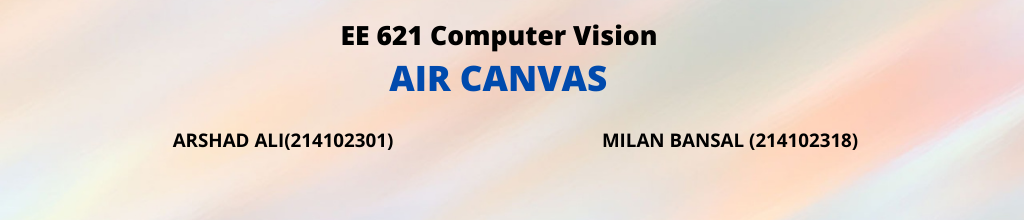

## Importing Modules

In [1]:
import numpy as np
import cv2
import mediapipe as mp
import os

## Hand Detector Class

In [2]:
class handDetector():
    def __init__(self, mode=False, maxHands=2,modelComplexity=1, detectionCon=0.5, trackCon=0.5):
        self.mode = mode
        self.maxHands = maxHands
        self.detectionCon = detectionCon
        self.trackCon = trackCon
 
        self.mpHands = mp.solutions.hands
        self.hands = self.mpHands.Hands(self.mode, self.maxHands,modelComplexity,
                                        self.detectionCon, self.trackCon)
        self.mpDraw = mp.solutions.drawing_utils
        
        self.tipIds = [4,8,12,16,20]
 
    def findHands(self, img, draw=True):
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.results = self.hands.process(imgRGB)
        
 
        if self.results.multi_hand_landmarks:
            for handLms in self.results.multi_hand_landmarks:
                if draw:
                    self.mpDraw.draw_landmarks(img, handLms,
                                               self.mpHands.HAND_CONNECTIONS)
        return img
 
    def findPosition(self, img, handNo=0, draw=True):
         # Finding posions of landmark poins
        self.lmList = []
        if self.results.multi_hand_landmarks:
            myHand = self.results.multi_hand_landmarks[handNo]
            for id, lm in enumerate(myHand.landmark):
                # print(id, lm)
                h, w, c = img.shape
                cx, cy = int(lm.x * w), int(lm.y * h)
                # print(id, cx, cy)
                self.lmList.append([id, cx, cy])
                if draw:
                    cv2.circle(img, (cx, cy), 7, (255, 0, 255), cv2.FILLED)
 
        return self.lmList

    def fingersUp(self):
        ## Checking for which fingers are up
        fingers = []
        if self.lmList[self.tipIds[0]][1]>self.lmList[self.tipIds[0] - 1][1]:
            fingers.append(1)
        else:
            fingers.append(0)
            
        for id in range(1, 5):
            if self.lmList[self.tipIds[id]][2]<self.lmList[self.tipIds[id]-2][2]:
                fingers.append(1)
            else:
                fingers.append(0)
        return fingers
 

## Air Canvas Program

In [3]:
#######################
brushThickness = 3
eraserThickness = 20
########################


folderPath = "Header"
myList = os.listdir(folderPath)
print(myList)
overlayList = []
for imPath in myList:
    image = cv2.imread(f'{folderPath}/{imPath}')
    overlayList.append(image)
print(len(overlayList))
header = overlayList[0]
drawColor = (255, 0, 255)

cap = cv2.VideoCapture(1)
cap.set(3, 640)
cap.set(4, 480)



detector = handDetector(detectionCon=0.7,maxHands=1)
xp, yp = 0, 0
imgCanvas = np.zeros((480, 640, 3), np.uint8)


while True:

    # 1. Import image
    success, img = cap.read()
    img = cv2.flip(img, 1)

    # 2. Find Hand Landmarks
    img = detector.findHands(img)
    lmList = detector.findPosition(img, draw=False)

    if len(lmList) != 0:

        # print(lmList)

        # tip of index and middle fingers
        x1, y1 = lmList[8][1:]
        x2, y2 = lmList[12][1:]

        # 3. Check which fingers are up
        fingers = detector.fingersUp()
        # print(fingers)

        # 4. If Selection Mode - Two finger are up
        if fingers[1] and fingers[2]:
            xp, yp = 0, 0
            ##print("Selection Mode")
            # # Checking for the click
            if y1 < 100:
                if 40 < x1 < 150:
                    header = overlayList[0]
                    drawColor = (255, 0, 255)
                elif 170 < x1 < 280:
                    header = overlayList[1]
                    drawColor = (0, 0, 255)
                elif 300 < x1 < 410:
                    header = overlayList[2]
                    drawColor = (0, 255, 0)
                elif 450 < x1 <620 :
                    header = overlayList[3]
                    drawColor = (0, 0, 0)
            cv2.rectangle(img, (x1, y1 - 25), (x2, y2 + 25), drawColor, cv2.FILLED)

        # 5. If Drawing Mode - Index finger is up
        if fingers[1] and fingers[2] == False:
            cv2.circle(img, (x1, y1), 5, drawColor, cv2.FILLED)
            ##print("Drawing Mode")
            if xp == 0 and yp == 0:
                xp, yp = x1, y1

            cv2.line(img, (xp, yp), (x1, y1), drawColor, brushThickness)

            if drawColor == (0, 0, 0):
                cv2.line(img, (xp, yp), (x1, y1), drawColor, eraserThickness)
                cv2.line(imgCanvas, (xp, yp), (x1, y1), drawColor, eraserThickness)
        
            else:
                cv2.line(img, (xp, yp), (x1, y1), drawColor, brushThickness)
                cv2.line(imgCanvas, (xp, yp), (x1, y1), drawColor, brushThickness)

            xp, yp = x1, y1


        # # Clear Canvas when all fingers are up
        if all (x >= 1 for x in fingers):
            imgCanvas = np.zeros((480, 640, 3), np.uint8)

    imgGray = cv2.cvtColor(imgCanvas, cv2.COLOR_BGR2GRAY)
    _, imgInv = cv2.threshold(imgGray, 50, 255, cv2.THRESH_BINARY_INV)
    imgInv = cv2.cvtColor(imgInv,cv2.COLOR_GRAY2BGR)
    img = cv2.bitwise_and(img,imgInv)
    img = cv2.bitwise_or(img,imgCanvas)


    # Setting the header image
    img[0:100, 0:640] = header
    ##img = cv2.addWeighted(img,0.5,imgCanvas,0.5,0)
    cv2.imshow("Image", img)
    ##cv2.imshow("Canvas", imgCanvas)
    ##cv2.imshow("Inv", imgInv)
    if cv2.waitKey(1) & 0xFF ==ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
    
    


['1.png', '2.png', '3.png', '4.png', 'Banner.png']
5
